In [1]:
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib_fontja  # noqa: F401
import pandas as pd
from japanmap import get_data, pref_names, pref_points
from shapely.geometry import Polygon

データダウンロード: https://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-N03-v2_2.html (2024年12月6日アクセス)

In [2]:
DIRPATH_DATA = Path("../data")
filepath_shp = Path(DIRPATH_DATA, "N03-180101_GML/N03-18_180101.shp")
filepath_shp

PosixPath('../data/N03-180101_GML/N03-18_180101.shp')

In [3]:
gdf_geometry: gpd.GeoDataFrame = gpd.read_file(filepath_shp)
gdf_geometry.head()

,N03_001,N03_002,N03_003,N03_004,N03_007,geometry
0,北海道,石狩振興局,札幌市,中央区,01101,"POLYGON ((141.34233 43.06682, 141.34285 43.066..."
1,北海道,石狩振興局,札幌市,北区,01102,"POLYGON ((141.40839 43.18395, 141.40833 43.183..."
2,北海道,石狩振興局,札幌市,東区,01103,"POLYGON ((141.44707 43.15616, 141.44694 43.155..."
3,北海道,石狩振興局,札幌市,白石区,01104,"POLYGON ((141.46244 43.1001, 141.46265 43.1000..."
4,北海道,石狩振興局,札幌市,豊平区,01105,"POLYGON ((141.38463 43.0467, 141.38479 43.0466..."


In [4]:
# 座標系の情報
gdf_geometry.crs

<Geographic 2D CRS: EPSG:6668>
Name: JGD2011
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Japan - onshore and offshore.
- bounds: (122.38, 17.09, 157.65, 46.05)
Datum: Japanese Geodetic Datum 2011
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [5]:
# 参考: https://lemulus.me/column/epsg-list-gis
original_epsg = 6668  # 地理座標系 (緯度経度)
projected_epsg = 3099  # UTM (メートル)

In [6]:
gdf_geometry.to_crs(projected_epsg).centroid.to_crs(original_epsg)

0         POINT (141.30206 43.03841)
1         POINT (141.35403 43.13474)
2         POINT (141.40131 43.10874)
3         POINT (141.42517 43.06032)
4         POINT (141.38895 42.99981)
                     ...            
116924    POINT (122.98994 24.47182)
116925     POINT (122.9658 24.47185)
116926    POINT (122.99026 24.47259)
116927    POINT (122.98894 24.45537)
116928     POINT (127.8434 26.43443)
Length: 116929, dtype: geometry

<Axes: >

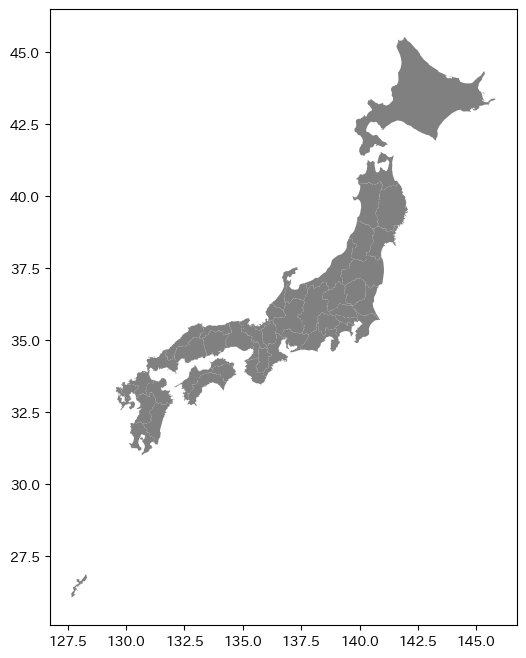

In [7]:
# 表示用のfigure作成
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# 日本地図のポリゴンデータ作成しGeoDataFrameに格納
gdf_pref = gpd.GeoDataFrame(
    crs=f"epsg:{original_epsg}",
    geometry=[Polygon(points) for points in pref_points(get_data())],
)
gdf_pref["prefecture"] = pref_names[1:]  # 県名を格納
# 日本地図をプロット
gdf_pref.plot(
    ax=ax,
    color="gray",  # 塗りつぶし色を指定
)
# gdf_geometry.plot(ax=ax)

<Axes: >

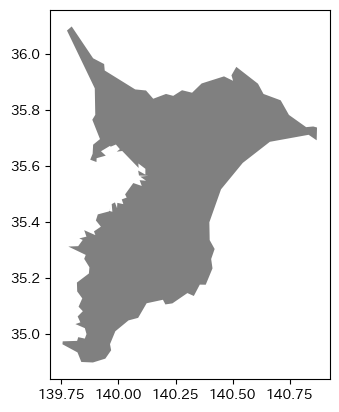

In [8]:
gdf_chiba: gpd.GeoDataFrame = gdf_pref.loc[
    gdf_pref.loc[:, "prefecture"] == "千葉県"
]
gdf_chiba.plot(color="gray")

In [9]:
gdf_chiba_centroid = gdf_chiba.to_crs(projected_epsg).centroid.to_crs(
    original_epsg
)
gdf_chiba_centroid

11    POINT (140.20439 35.51091)
dtype: geometry

<Axes: >

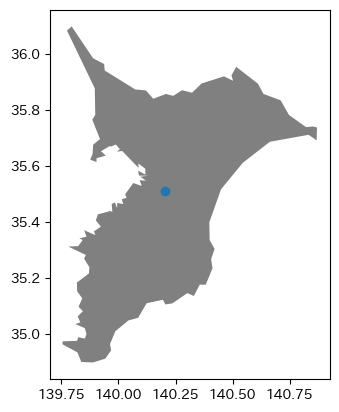

In [10]:
fig, ax = plt.subplots()
gdf_chiba.plot(ax=ax, color="gray")
gdf_chiba.to_crs(projected_epsg).centroid.to_crs(original_epsg).plot(ax=ax)

<Axes: >

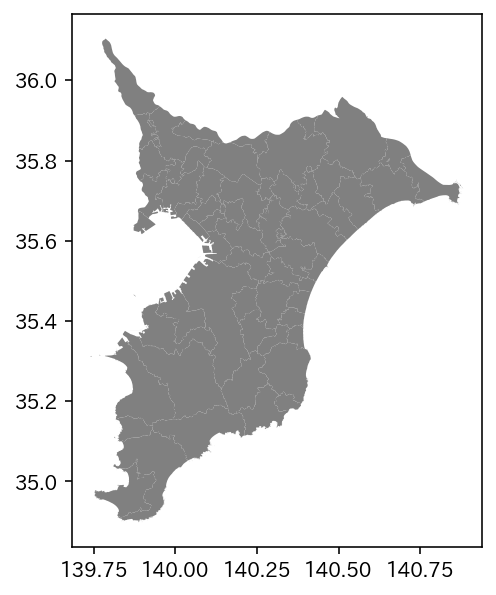

In [11]:
fig, ax = plt.subplots(dpi=144)
gdf_chiba_with_shikuchouson = gdf_geometry.loc[
    gdf_geometry.iloc[:, 0] == "千葉県"
]
gdf_chiba_with_shikuchouson.plot(color="gray", ax=ax)

In [12]:
_df_area_shikuchouson = pd.concat(
    (
        gdf_chiba_with_shikuchouson.to_crs(projected_epsg)
        .centroid.to_crs(original_epsg)
        .x.rename("x座標"),
        gdf_chiba_with_shikuchouson.to_crs(projected_epsg)
        .centroid.to_crs(original_epsg)
        .y.rename("y座標"),
        (
            gdf_chiba_with_shikuchouson.iloc[:, 2].fillna("")
            + gdf_chiba_with_shikuchouson.iloc[:, 3].fillna("")
        ).rename("市区町村"),
        gdf_chiba_with_shikuchouson.to_crs(projected_epsg).area.rename("面積"),
    ),
    axis=1,
)
# 市区町村のうち、最大の部分だけを準備
# (小さい島に文字が重なって読みにくい)
_df_area_shikuchouson = _df_area_shikuchouson.loc[
    _df_area_shikuchouson.groupby("市区町村")["面積"].idxmax()
]
_df_area_shikuchouson.head()

,x座標,y座標,市区町村,面積
32118,140.343306,35.277765,いすみ市,1.582875e+08
31281,140.213235,35.706187,佐倉市,1.041230e+08
31344,140.105024,35.739205,八千代市,5.161790e+07
31682,140.296854,35.642399,八街市,7.530012e+07
31325,140.267602,35.175180,勝浦市,9.455099e+07


<Axes: >

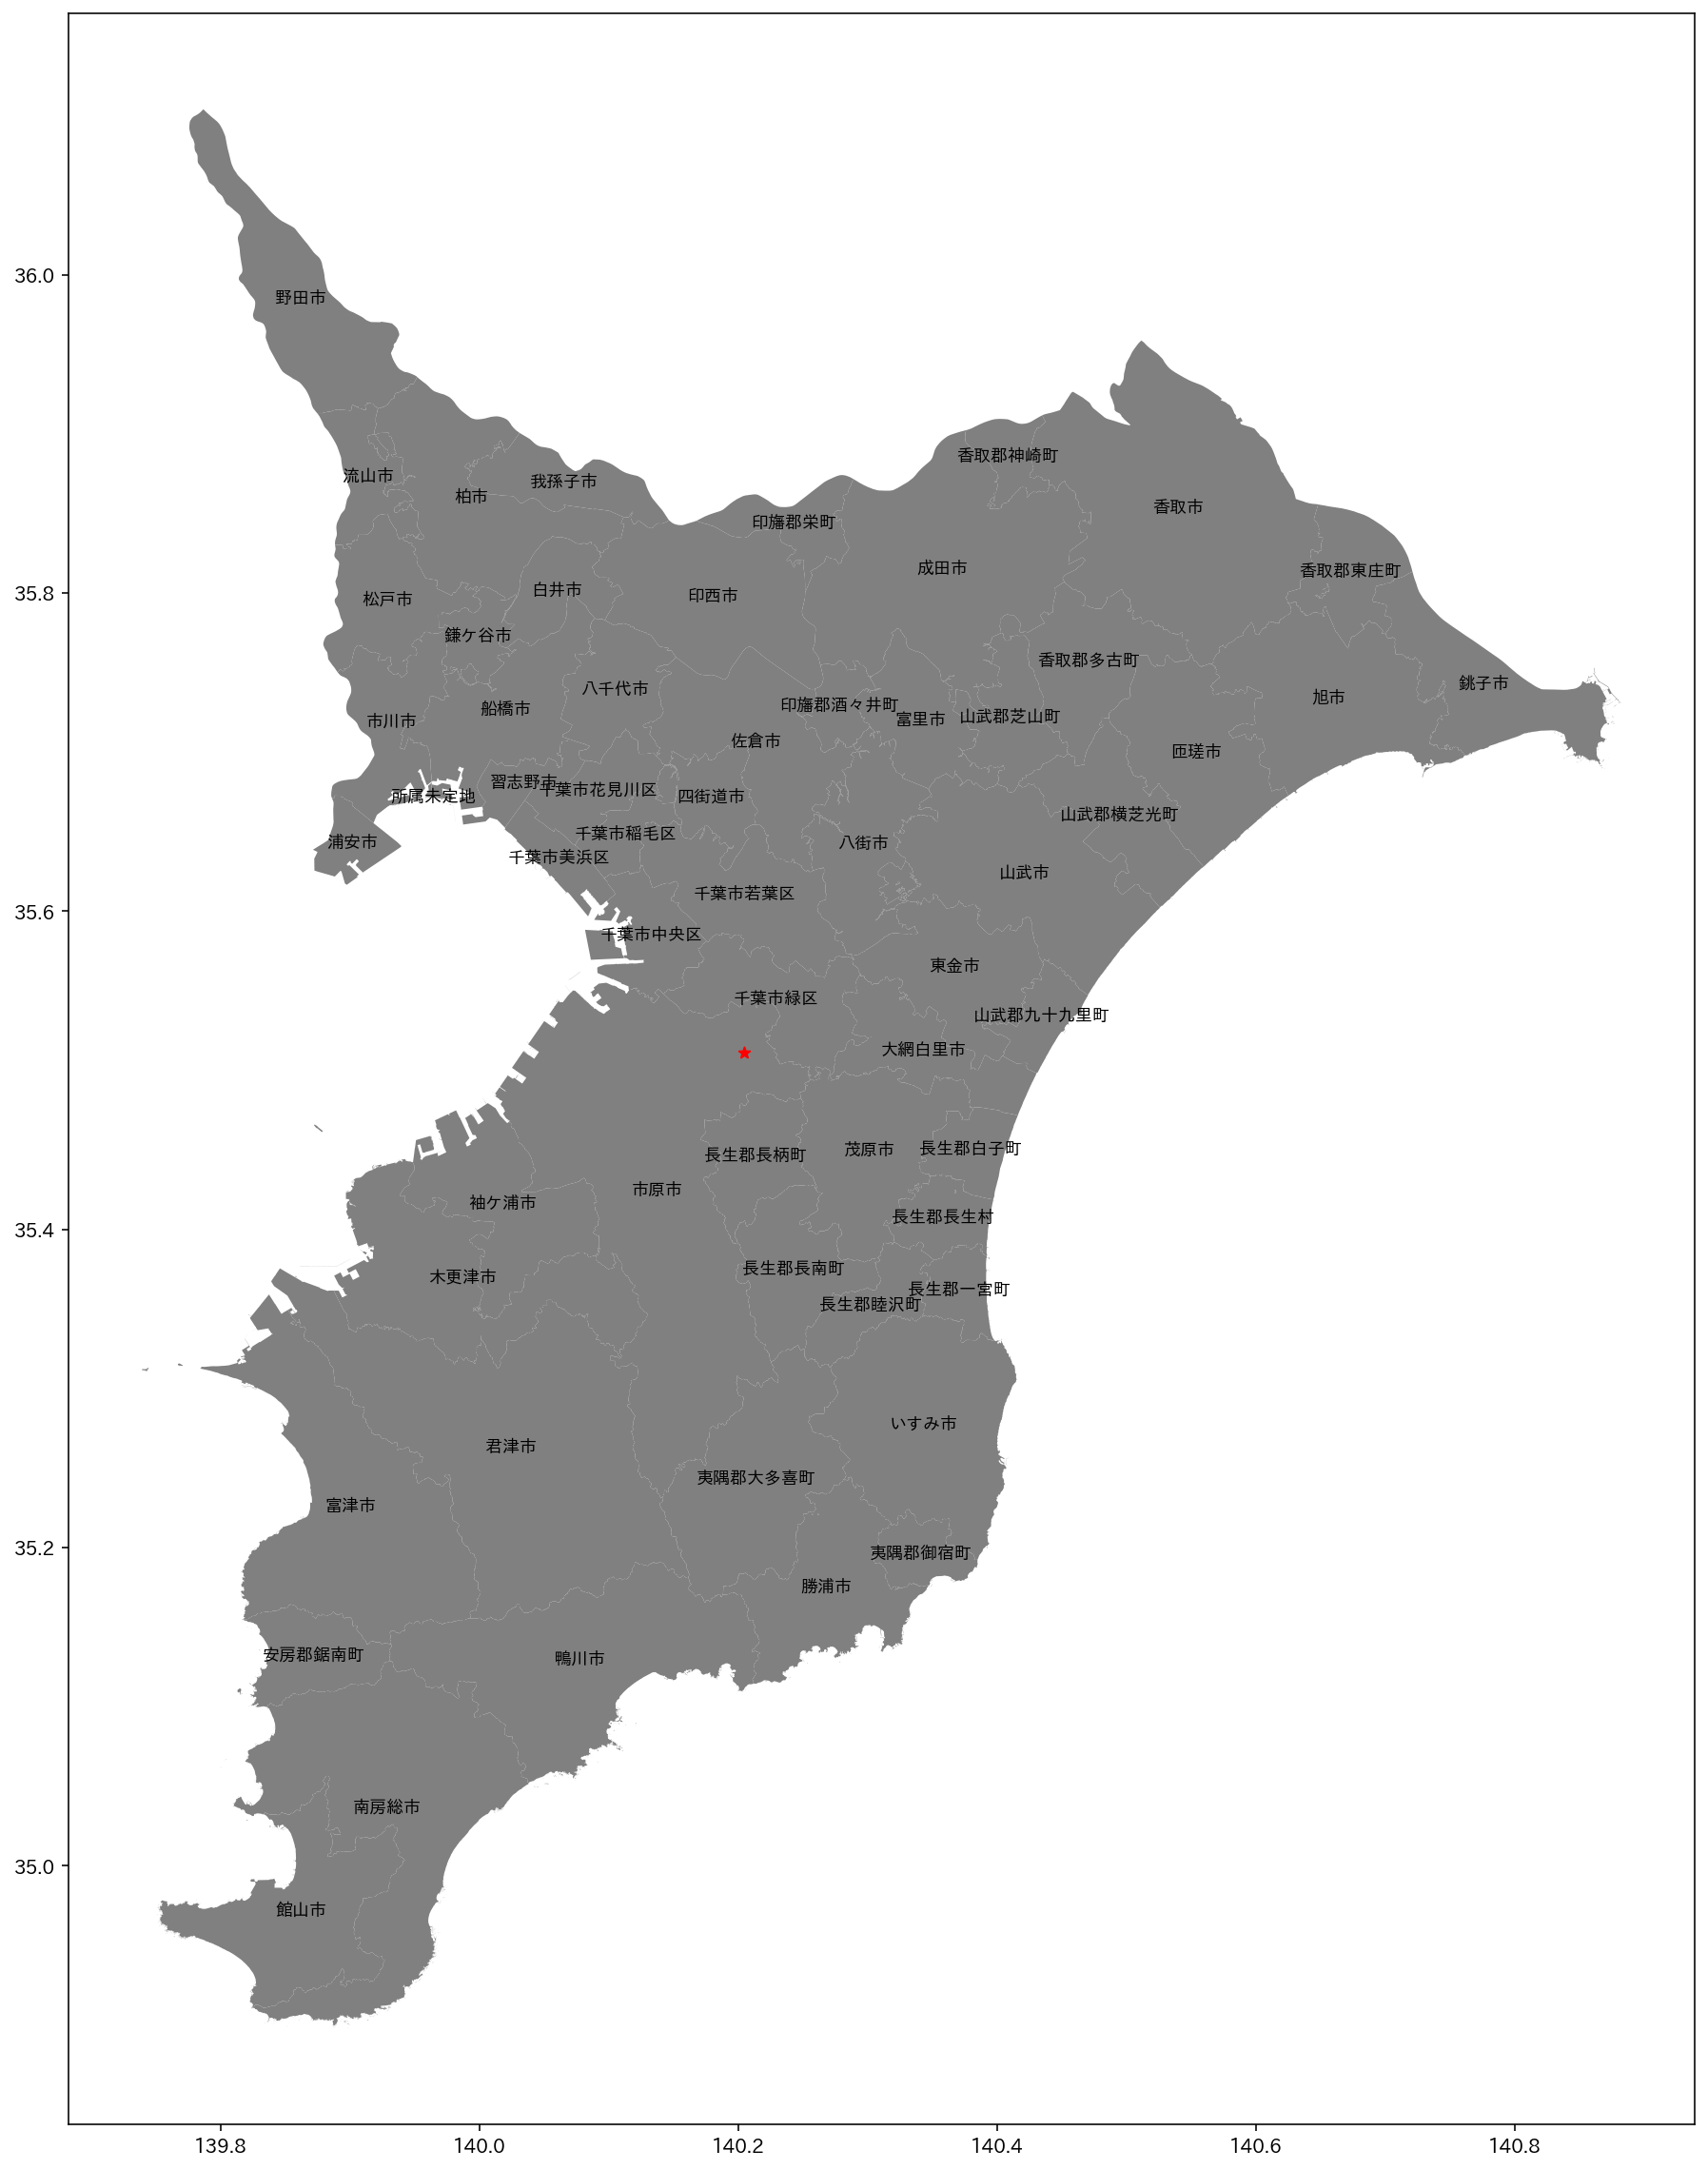

In [13]:
fig, ax = plt.subplots(figsize=(20, 20), dpi=144)
gdf_chiba_with_shikuchouson.plot(color="gray", ax=ax)
for _, sr in _df_area_shikuchouson.iterrows():
    ax.text(
        x=sr["x座標"],
        y=sr["y座標"],
        s=sr["市区町村"],
        fontdict=dict(size=9),
        ha="center",
        va="center",
    )
gdf_chiba.to_crs(projected_epsg).centroid.to_crs(original_epsg).plot(
    ax=ax, marker="*", color="red"
)

In [14]:
# 重心をGooglemapで開く
f"https://www.google.com/maps?q={gdf_chiba_centroid.y.item()},{gdf_chiba_centroid.x.item()}"

'https://www.google.com/maps?q=35.51090696500235,140.20438926705094'

## 参考

- [【PythonでGIS】GeoPandasまとめ - Qiita](https://qiita.com/c60evaporator/items/ac6a6d66a20520f129e6)